# Unlocking Church Growth: Data Insights from the National Congregations Study

**Author**: Nathan Schaaf <br>
**Date**: July 10, 2024

## References
Chaves, M. (2021, January 25). National Congregations Study, Cumulative Dataset (1998, 2006-2007, 2012, and 2018-2019). The Association of Religion Data Archives. doi:10.17605/OSF.IO/V5ZKB. https://www.thearda.com/data-archive?fid=NCSIV.


## Objective / Thesis
How can we increase our church attendance? In this analysis we explore the "National Congregations Study, Cumuliative Dataset (1998, 2006-2007, 2012, and 2018-2019)" to look for correlations between congregational offerings such as facilities, worship services, staffing, music, and programs and an increase congregational size. The dataset includes over 5,000 congregations sampled through in-person interviews in four periods between 1998 and 2019. This analysis is inteded for decision-makers within religious congregations.

## Data Understanding and Preparation
Data Cleaning: Ensure the dataset is clean, dealing with missing values, and outliers. <br>
Data Transformation: Create relevant variables, such as attendance growth rates, and standardize/normalize data if necessary.

### Dependencies
Import libraries needed for this notebook. These may be used in a future requirements.txt file for modular project development.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from scipy.stats import spearmanr, pearsonr, chi2_contingency, fisher_exact
from scipy.stats.contingency import relative_risk
from scipy.stats.contingency import odds_ratio
from scipy.stats import f_oneway  # Inferential Analysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE # Rancom Forest oversampling


# Import DictionaryCollection class from Dictionaries.py
    # Download the file from GitHub
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/notebook/dictionaries.py'
response = requests.get(url)

    # Save the file locally
with open('dictionaries.py', 'wb') as file:
    file.write(response.content)
from dictionaries import dictionaryCollection

Unfortunately, the data source altered all categorical data into ordinal values and all Boolean data into ‘1’ and ‘2’, yes/no respectively. The above dictionaries.py file implements the provided translational text documents from the data source by converting the ordinal values back into categorical data. It also converts the 2’s into 0 achieving standard Boolean representation to avoid confusion and modeling issues.

In [2]:
# Load Data
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/dataset/dataset.csv'
data = pd.read_csv(url)

Loading the dataset directly from the GitHub repository can aid others in reviewing, replicating, or continuting this analysis. Unfortuantly, no APIs were avaialble to access the dataset directly from the source.

In [3]:
# Initialize DictionaryCollection instance
dict_collection = dictionaryCollection()

# Replace numerical values column with string values from dictionaries
data = dict_collection.replace_numeric_values(data)

Create a custom theme for all Seaborn visualizations.

In [4]:
def set_seaborn_style(font_family, background_color, grid_color, text_color):
    sns.set_style({
        "axes.facecolor": background_color,
        "figure.facecolor": background_color,

        "grid.color": grid_color,
        "axes.edgecolor": grid_color,
        "axes.grid": True,
        "axes.axisbelow": True,
        
        "axes.labelcolor": text_color,
        "text.color": text_color,
        "font.family": font_family,
        "xtick.color": text_color,
        "ytick.color": text_color,

        "xtick.bottom": False,
        "xtick.top": False,
        "ytick.left": False,
        "ytick.right": False,

        "axes.spines.left": False,
        "axes.spines.bottom": True,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

background_color = "#006064"
grid_color = "#cccccc"
bar_color = "#009688"
text_color = "#ffffff"
font_family = "Arial"

set_seaborn_style(font_family, background_color, grid_color, text_color)

The denomination is a key categorical feature of the dataset for the analysis reader. Religious beliefs can influence behaviors, values, lifestyle choice and practices of a congregation and its members. They can also play a crucial role in social interactions and cultural norms. Since there is over 60 denominations surveyed in this dataset, a custom color palette for denominations has been created below so each is represented by a consistent color in any visual analytics. 

In [5]:
# Create a custom color palette for all denominations
denominations = data['DENOM'].unique()
colors = sns.color_palette('Set2', len(denominations))
custom_palette = dict(zip(denominations, colors))

### Data Transformation

In [6]:
# Create new features based on conditions
data['change_increase'] = np.where(data['CHANGE'].str.contains('Increased'), True, False)
data['change_decrease'] = np.where(data['CHANGE'].str.contains('Decreased'), True, False)
data['change_category'] = data['CHANGE'].apply(
    lambda x: "Increase" if "Increased" in str(x) else ("Decrease" if "Decreased" in str(x) else ("Same" if "Same" in str(x) else "Same"))
)

In [7]:
# Change column data types
data['DENOM'] = data['DENOM'].astype('category')
data['change_category'] = data['change_category'].astype('category')

### Data Cleaning

In [8]:
# Select specific features
selected_columns = ['DENOM', 'change_increase', 'change_decrease']
df = data[selected_columns].copy()

In [12]:
# Select specific features
selected_columns = ['DENOM', 'NUMSERV1', 'LENGTH', 'SERMON', 'SERMTIME', 'SPKRDWN', 'NUMSPOKE', 'GREET', 'KIDTIME', 'TEENPART', 'ROBE', 'APPLAUSE', 'LAUGH', 'PROGRAM', 'OVERHEAD', 'STREAMED', 'SMTPHONE', 'CONGREAD', 'OFFERING', 'SOCLTIME', 'change_category']
df_worship = data[selected_columns].copy()

In [13]:
# Select specific features
selected_columns = ['DENOM', 'CLSYACS', 'CLSADLT', 'YTHGRP', 'TEENCHOR', 'TEENCAMP', 'TEENVOL', 'POLITICS', 'DISBIBLE', 'BOOKS', 'PARENTS', 'VOTERREG', 'SCIENCE', 'ENVIRON', 'ORGVOLS', 'WORKPROB', 'NEWMEMS', 'TRAIN', 'RACEREL', 'OTHTRAD', 'OWNMONY', 'CONGMONY', 'ASSESS', 'MARRIAGE', 'WOMENGRP', 'MENGRP', 'EXERCISE', 'LGBT', 'change_increase', 'change_decrease']
df_programs = data[selected_columns].copy()

## Descriptive Analysis
Summary Statistics: Compute basic statistics (mean, median, mode) for variables related to facilities, worship services, staffing, music, programs, and congregational size. <br>
Distribution Analysis: Visualize the distributions of key variables to understand their spread and central tendency.

### Source Dataframe

In [14]:
# Basic Exploration
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Columns: 1091 entries, CASEID to change_category
dtypes: bool(2), category(2), float64(1020), int64(11), object(56)
memory usage: 44.3+ MB


,CASEID,YEAR,REGION,POS1,RTENURE,FOUNDED,STRTWRSH,HAVEDEN,DENCODE,DENCODE3,...,WT_WAVE4_ATTENDEE,POOR30_ALL4,BLCK80_4,HISPANIC_ALL4,URBAN_ALL4,I_YEAR,I_REGION,I_THEOLOGY,I_POLITICS,I_RELIGION
count,5333.000000,5333.000000,5333.000000,5319.000000,1502.000000,5171.000000,1191.000000,5333.000000,5333.000000,5333.000000,...,744.000000,5329.000000,5330.000000,5330.000000,5330.000000,5333.000000,5333.000000,5187.000000,5068.000000,5333.000000
mean,2667.147197,2008.486030,2.638477,3.272984,128.674434,1930.442854,1945.212427,1.140446,12.775923,9.372773,...,1.000000,0.127979,0.046529,1.457036,1.493621,2.491468,2.638477,1.558319,1.588595,2.434652
std,1539.866293,7.190217,0.951268,3.919739,126.914571,54.868910,45.026279,0.347482,13.220951,8.651988,...,0.697084,0.334098,0.210648,0.498197,0.783615,1.089132,0.951268,0.685803,0.666551,1.180175
min,1.000000,1998.000000,1.000000,1.000000,0.000000,1588.000000,1719.000000,1.000000,1.000000,1.000000,...,0.279499,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1334.000000,2006.000000,2.000000,1.000000,36.000000,1891.000000,1920.000000,1.000000,2.000000,2.000000,...,0.501924,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,2667.000000,2006.000000,3.000000,1.000000,84.000000,1943.000000,1958.000000,1.000000,6.000000,6.000000,...,0.801947,0.000000,0.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,4000.000000,2012.000000,3.000000,2.000000,180.000000,1975.000000,1979.000000,1.000000,21.000000,17.000000,...,1.140704,0.000000,0.000000,2.000000,2.000000,3.000000,3.000000,2.000000,2.000000,4.000000
max,5334.000000,2018.000000,4.000000,14.000000,840.000000,2018.000000,1998.000000,2.000000,39.000000,24.000000,...,4.919342,1.000000,1.000000,2.000000,3.000000,4.000000,4.000000,3.000000,3.000000,5.000000


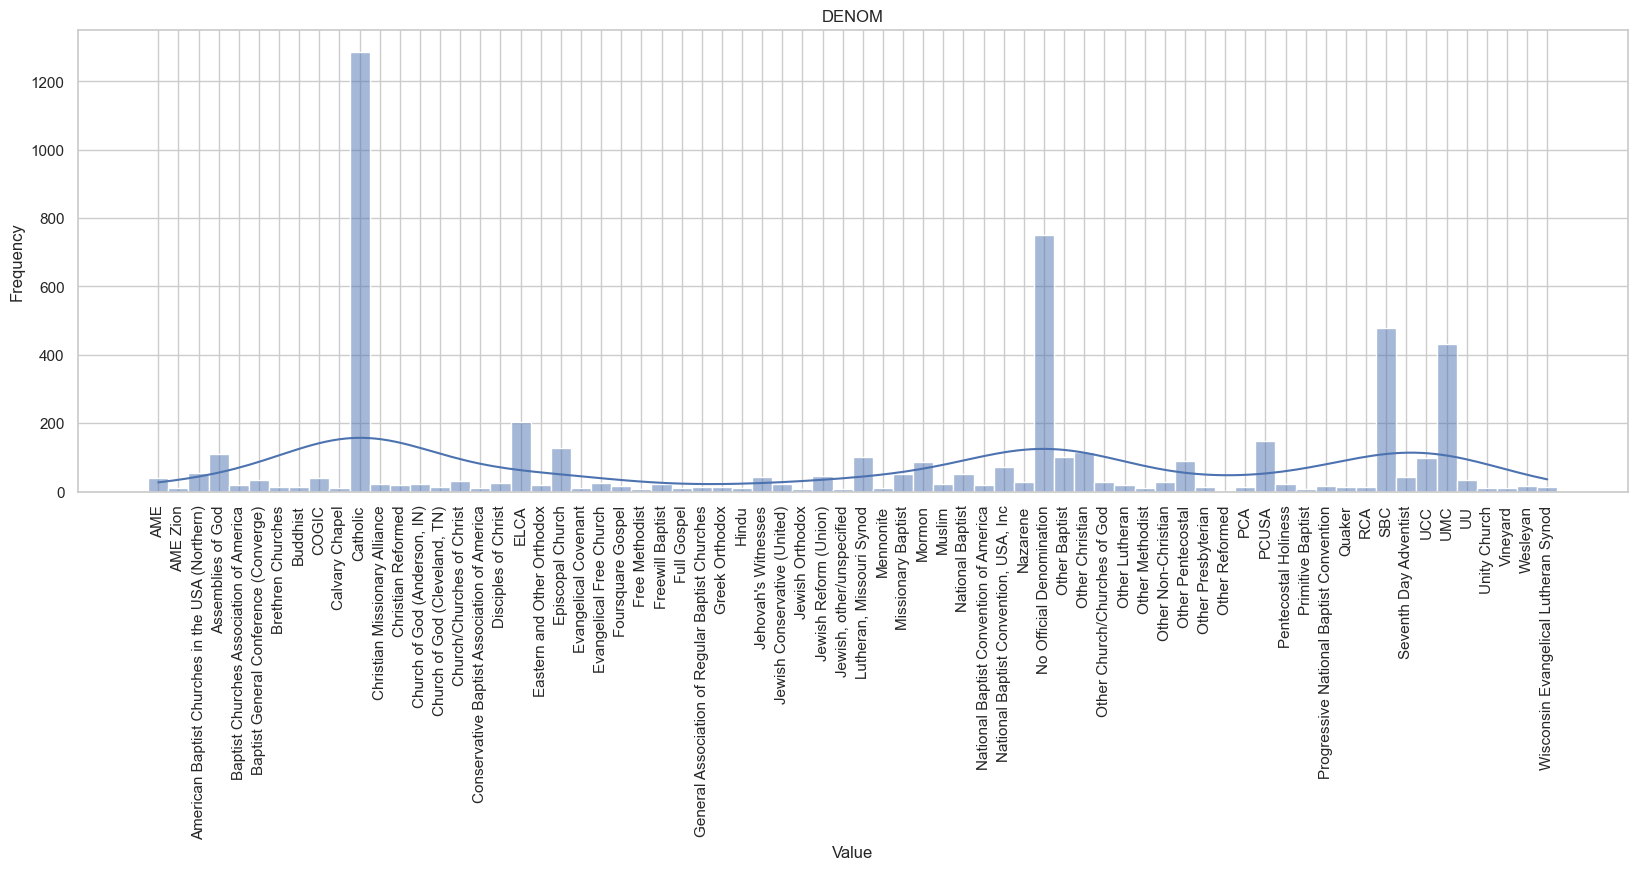

In [15]:
# Histogram of numerical features from select columns
columns_of_interest = ['DENOM']

sns.set(style="whitegrid")
plt.figure(figsize=(20, 6))

for i, column in enumerate(columns_of_interest, 1):
    plt.subplot(1, len(columns_of_interest), i)
    sns.histplot(data[column], bins=20, kde=True)
    plt.title(column)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)

C:\Users\natha\AppData\Local\Temp\ipykernel_7392\2589591519.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=denom_counts.index, y=denom_counts.values, palette=custom_palette, edgecolor=background_color, order=denom_counts.index)


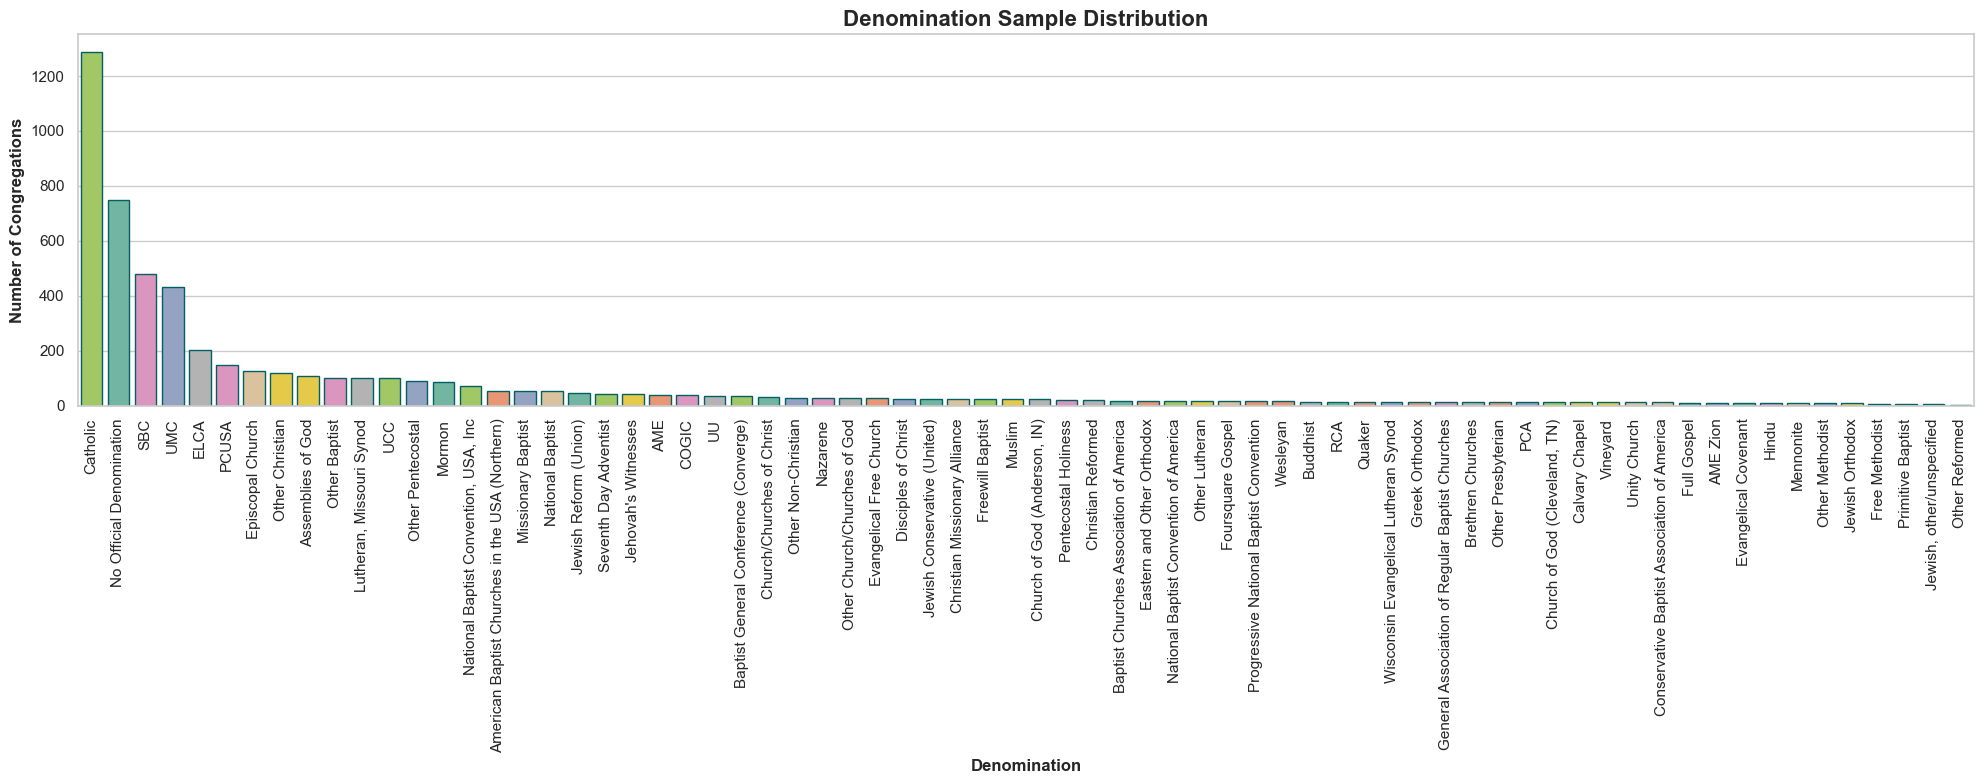

In [16]:
# Count the occurrences of each unique value in 'DENOM' column
denom_counts = data['DENOM'].value_counts().sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(20, 8))
sns.barplot(x=denom_counts.index, y=denom_counts.values, palette=custom_palette, edgecolor=background_color, order=denom_counts.index)

# Customize the plot
plt.title('Denomination Sample Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Denomination', fontsize=12, fontweight='bold')
plt.ylabel('Number of Congregations', fontweight='bold')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

### Worship

In [38]:
# Basic exploration
df_worship.info()
df_worship.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   DENOM            5324 non-null   category
 1   NUMSERV1         5322 non-null   float64 
 2   LENGTH           5321 non-null   float64 
 3   SERMON           5326 non-null   object  
 4   SERMTIME         5289 non-null   float64 
 5   SPKRDWN          2777 non-null   object  
 6   NUMSPOKE         1215 non-null   float64 
 7   GREET            5326 non-null   object  
 8   KIDTIME          1232 non-null   object  
 9   TEENPART         1232 non-null   object  
 10  ROBE             4095 non-null   object  
 11  APPLAUSE         5320 non-null   float64 
 12  LAUGH            1228 non-null   object  
 13  PROGRAM          5330 non-null   object  
 14  OVERHEAD         5326 non-null   object  
 15  STREAMED         1254 non-null   object  
 16  SMTPHONE         1255 non-null   object  


,NUMSERV1,LENGTH,SERMTIME,NUMSPOKE,APPLAUSE,SOCLTIME
count,5322.000000,5321.000000,5289.000000,1215.000000,5320.000000,4054.000000
mean,5.616967,81.415899,25.555493,3.688889,1.384211,32.827578
std,28.010125,38.381398,20.816414,5.416309,0.486454,26.042180
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,60.000000,15.000000,2.000000,1.000000,15.000000
50%,3.000000,70.000000,20.000000,3.000000,1.000000,30.000000
75%,7.000000,90.000000,35.000000,4.000000,2.000000,40.000000
max,2000.000000,1440.000000,600.000000,125.000000,2.000000,600.000000


In [39]:
# Drop DENOM
df_worship.drop(['DENOM'], axis=1, inplace=True)

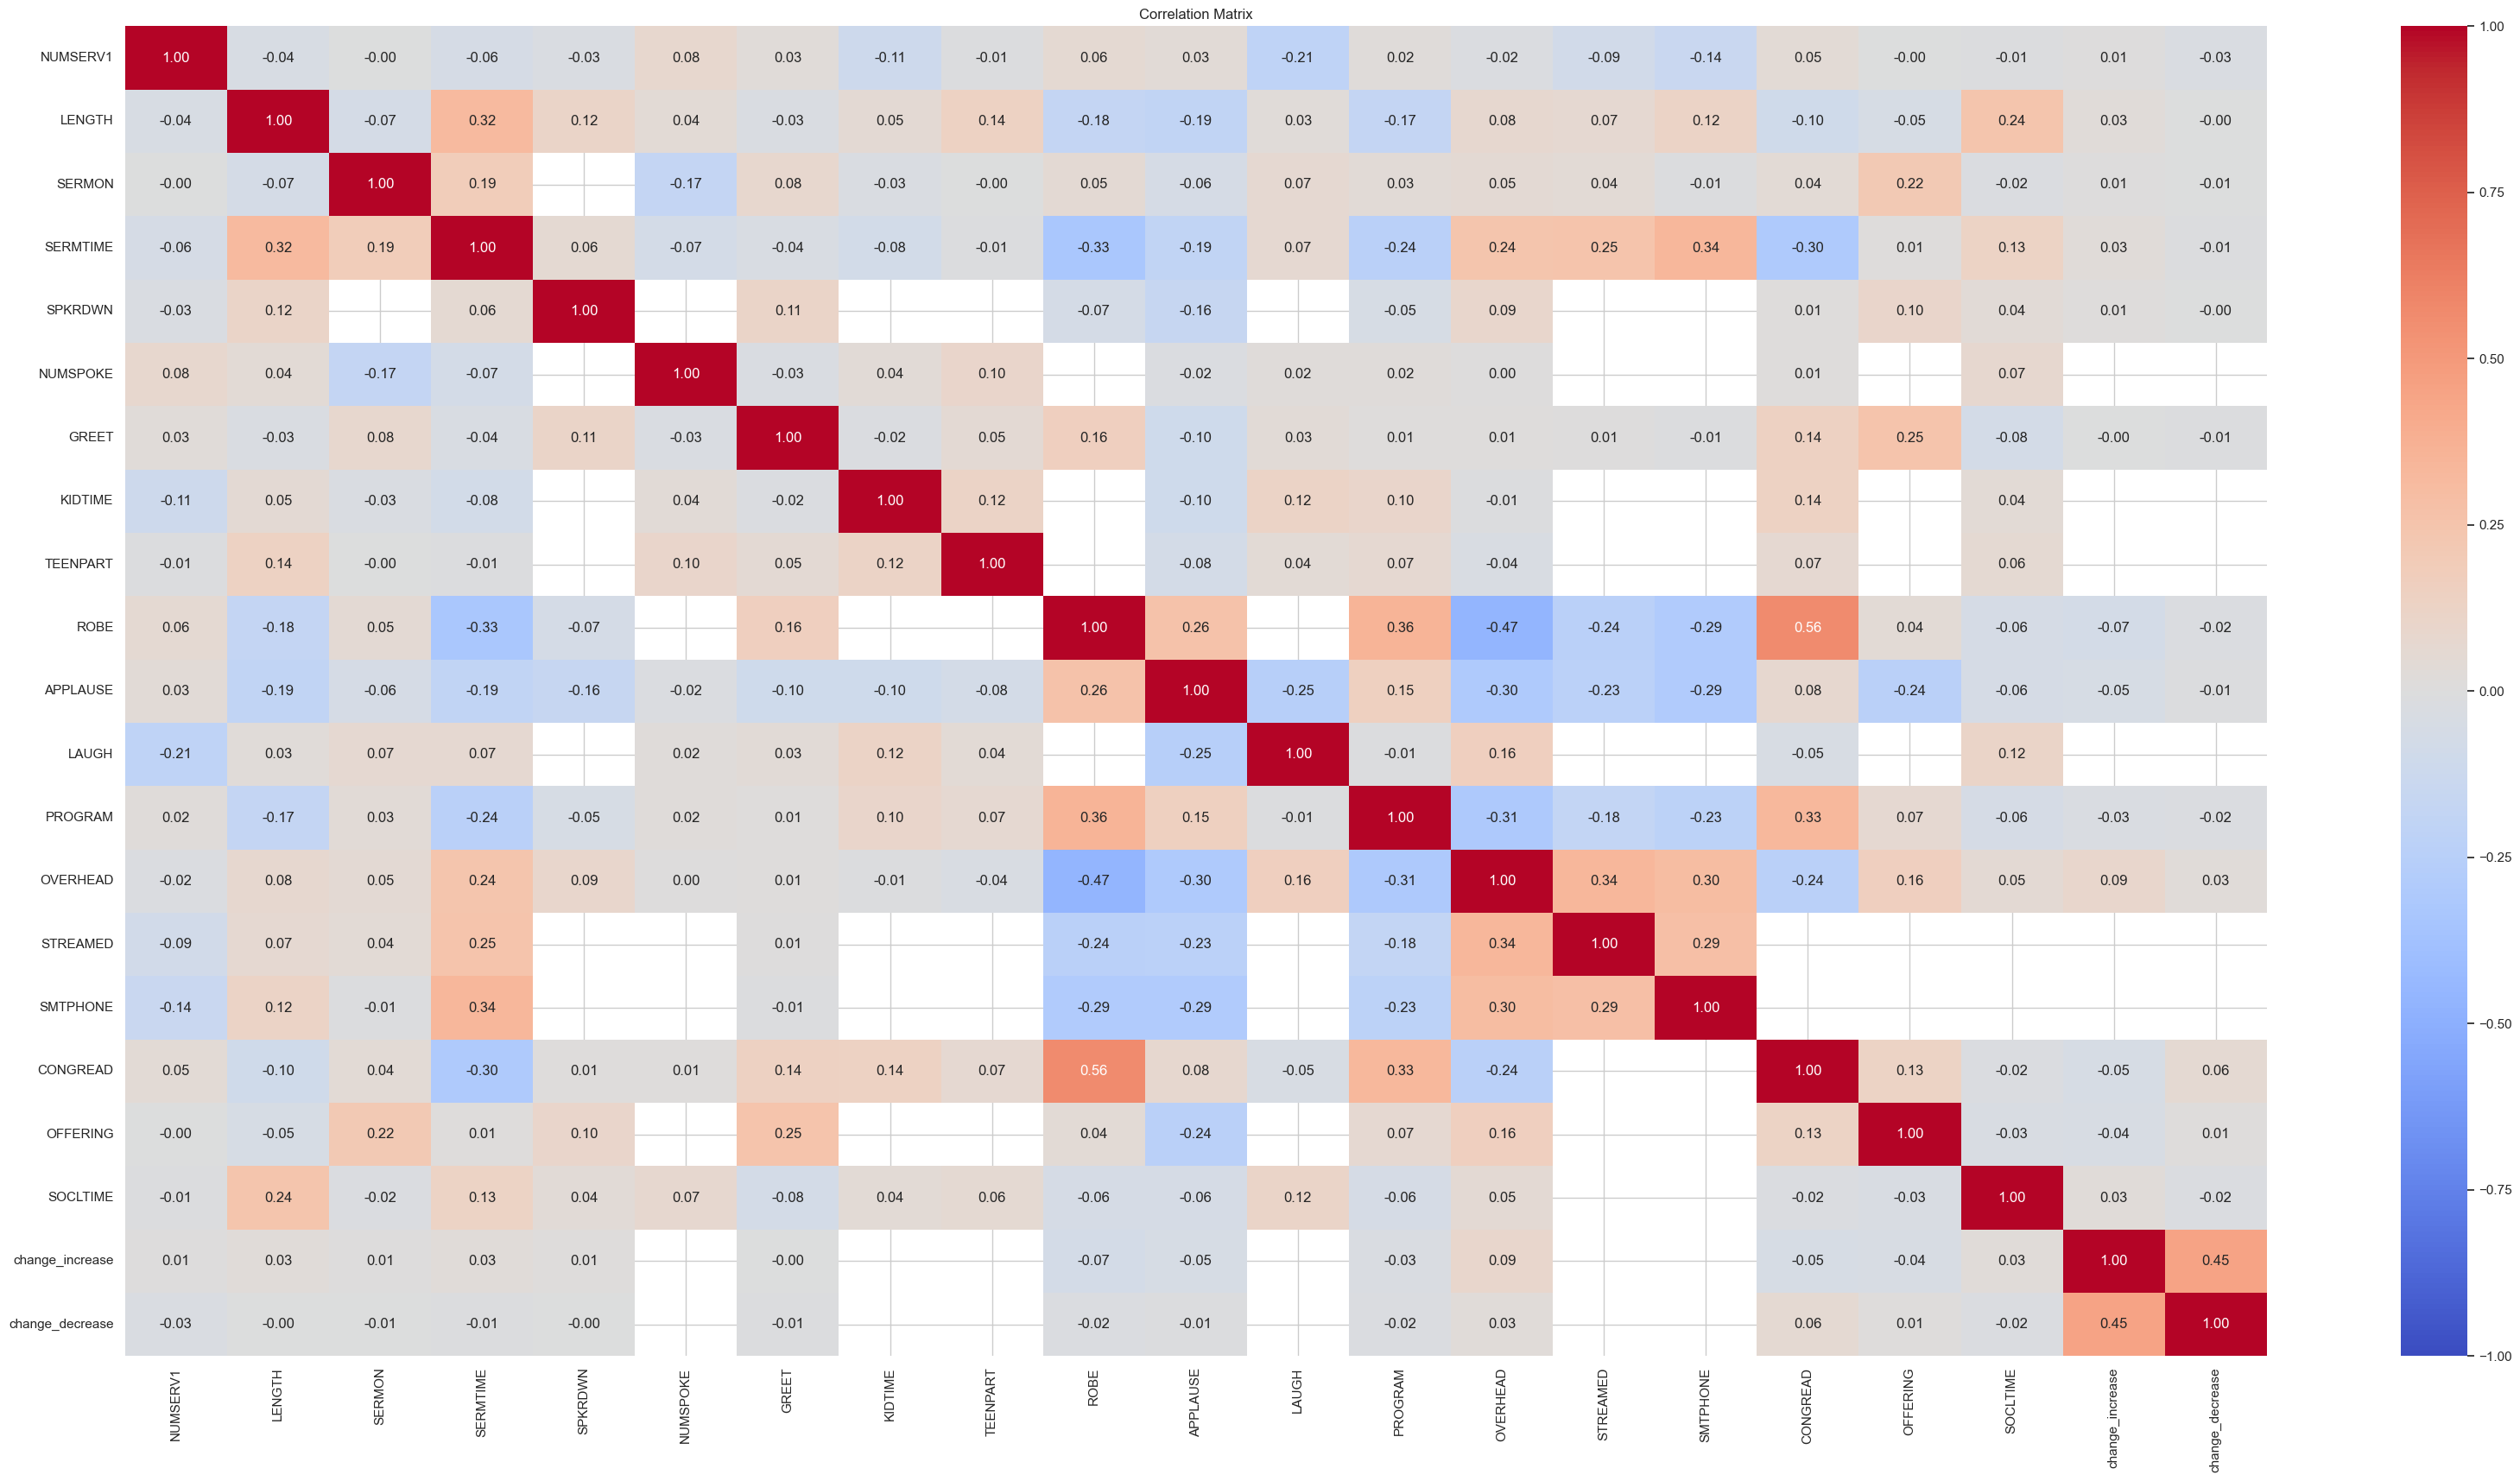

In [40]:
# Perform correlation analysis
correlation_matrix = df_worship.corr()

plt.figure(figsize=(40,20))  # Adjust the figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Add plot title and show plot
plt.title('Correlation Matrix')
plt.show()

### Programs

In [41]:
# Basic exploration
df_programs.info()
df_programs.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   DENOM            5324 non-null   category
 1   CLSYACS          1502 non-null   object  
 2   CLSADLT          1503 non-null   object  
 3   YTHGRP           1502 non-null   object  
 4   TEENCHOR         1503 non-null   object  
 5   TEENCAMP         1500 non-null   object  
 6   TEENVOL          1498 non-null   object  
 7   POLITICS         5311 non-null   object  
 8   DISBIBLE         1330 non-null   object  
 9   BOOKS            2729 non-null   object  
 10  PARENTS          2726 non-null   object  
 11  VOTERREG         5297 non-null   object  
 12  SCIENCE          1250 non-null   object  
 13  ENVIRON          2480 non-null   object  
 14  ORGVOLS          1227 non-null   object  
 15  WORKPROB         1228 non-null   object  
 16  NEWMEMS          2732 non-null   object  


,DENOM,CLSYACS,CLSADLT,YTHGRP,TEENCHOR,TEENCAMP,TEENVOL,POLITICS,DISBIBLE,BOOKS,...,OWNMONY,CONGMONY,ASSESS,MARRIAGE,WOMENGRP,MENGRP,EXERCISE,LGBT,change_increase,change_decrease
count,5324,1502,1503,1502,1503,1500,1498,5311,1330,2729,...,3804,2557,5307,1504,1331,1330,2583,1247,5333,5333
unique,70,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,Catholic,False,True,True,False,True,True,False,True,True,...,False,True,True,True,True,True,False,False,True,True
freq,1287,817,1289,1225,785,1220,1202,4579,1278,1458,...,2176,1639,3106,862,1131,1010,1385,917,4568,4064


In [42]:
# Drop DENOM
df_programs.drop(['DENOM'], axis=1, inplace=True)

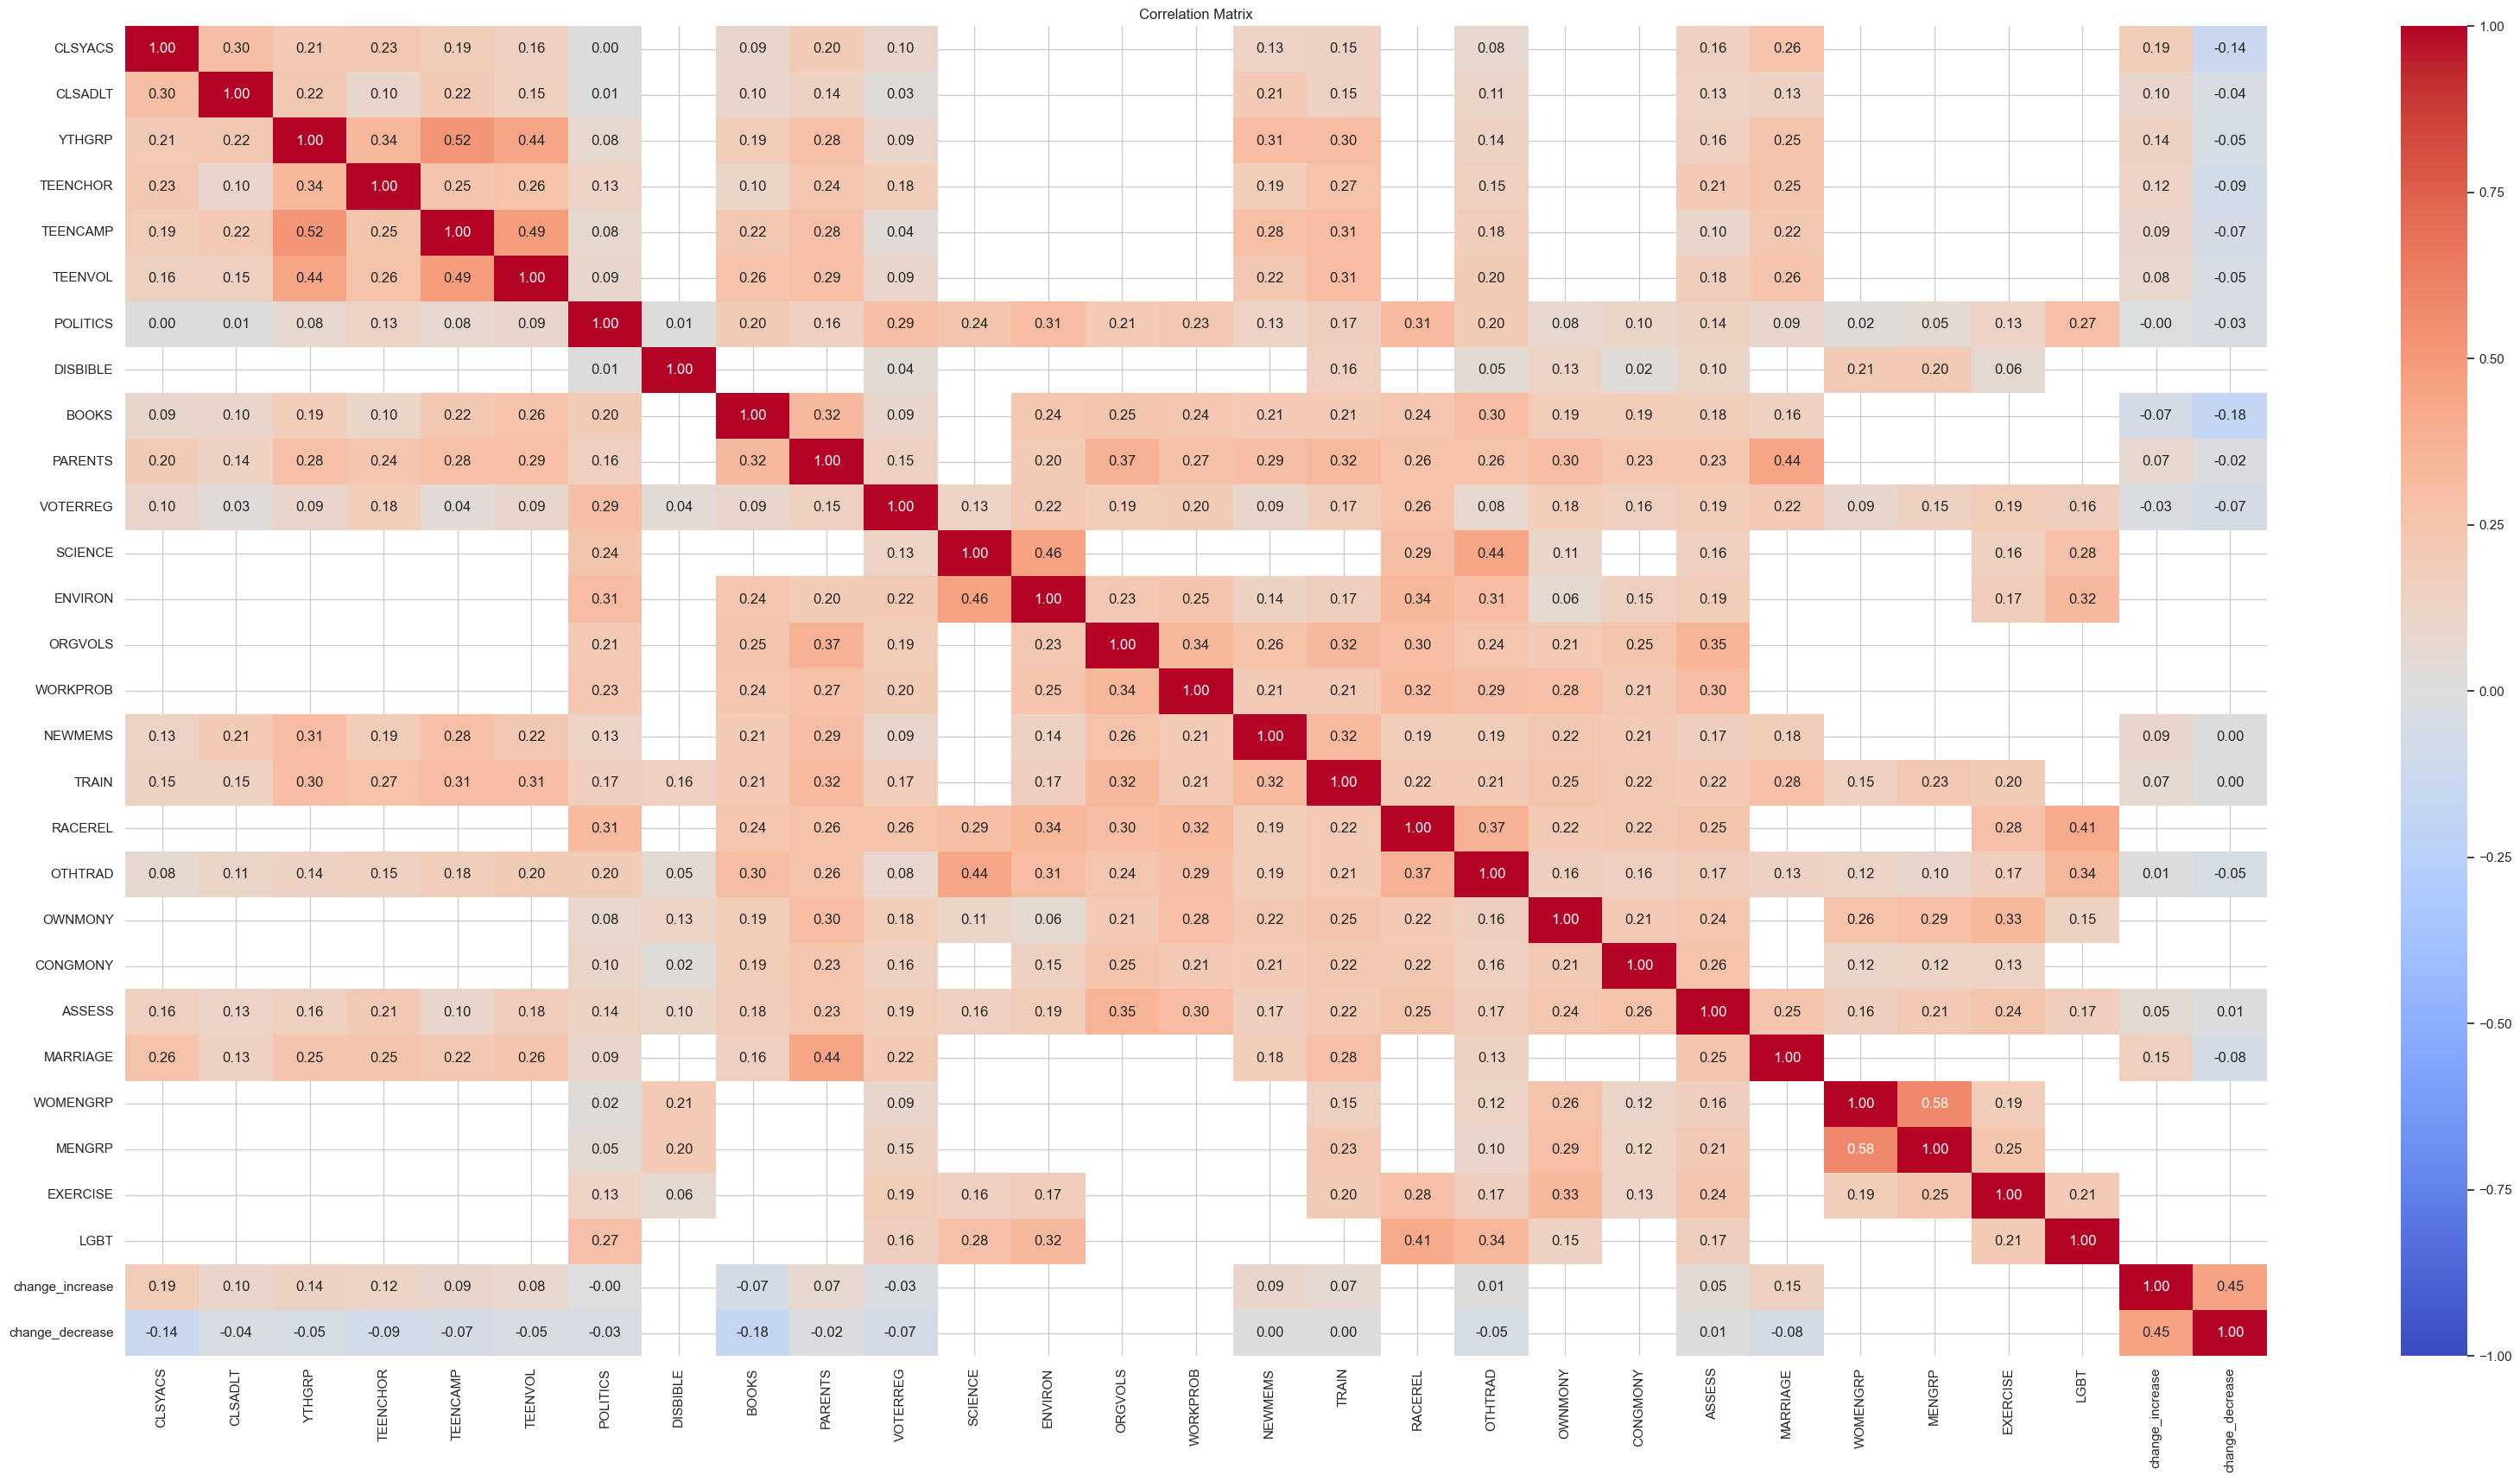

In [43]:
# Perform correlation analysis
correlation_matrix = df_programs.corr()

plt.figure(figsize=(40,20))  # Adjust the figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Add plot title and show plot
plt.title('Correlation Matrix')
plt.show()

In [44]:
# Create a contingency table
contingency_table = pd.crosstab(df_programs['CLSYACS'], df_programs['change_increase'])
print("Contingency Table:")
print(contingency_table)

Contingency Table:
change_increase  False  True 
CLSYACS                      
False              486    331
True               276    409


In [45]:
# Chi-square test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Square Test Results:")
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)


Chi-Square Test Results:
Chi-square statistic: 54.1540292389039
P-value: 1.8537336862842525e-13
Degrees of freedom: 1
Expected frequencies:
[[414.48335553 402.51664447]
 [347.51664447 337.48335553]]


In [46]:
# Calculate correlation coefficient and p-value
df_programs.dropna(subset=['CLSYACS'], inplace=True)
corr_coef, p_value = pearsonr(df_programs['CLSYACS'], df_programs['change_increase'])
print(f"Correlation Coefficient: {corr_coef}")
print(f"P-value: {p_value}")

Correlation Coefficient: 0.1912173972459238
P-value: 7.800188207516051e-14


In [47]:
# Calculate confidence interval for relative risk
log_rr = np.log(relative_risk)
se_log_rr = np.sqrt(1 / 486 - 1 / (486 + 762) + 1 / 331 - 1 / (331 + 740))
ci = np.exp(log_rr - 1.96 * se_log_rr), np.exp(log_rr + 1.96 * se_log_rr)

print(f"Relative Risk (CLSYACS=True vs CLSYACS=False): {relative_risk}")
print(f"95% Confidence Interval: {ci}")

TypeError: loop of ufunc does not support argument 0 of type function which has no callable log method

Relative Risk (RR):

If RR > 1: CLSYACS=True is associated with a higher likelihood of change_increase=True.
If RR < 1: CLSYACS=True is associated with a lower likelihood of change_increase=True.
If RR = 1: No association between CLSYACS and change_increase.


In [ ]:
# Construct contingency table
contingency_table = np.array([[409, 276],
                              [331, 486]])

# Calculate odds ratio and p-value using Fisher's exact test
odds_ratio, p_value = fisher_exact(contingency_table)

print(f"Odds Ratio (CLSYACS=True vs CLSYACS=False): {odds_ratio}")
print(f"P-value: {p_value}")

Odds Ratio (OR):

If OR > 1: Higher odds of change_increase when CLSYACS=True.
If OR < 1: Lower odds of change_increase when CLSYACS=True.
If OR = 1: No association between CLSYACS and change_increase. <br>
The p-value from Fisher's exact test tells you whether the observed association is statistically significant. Typically, a p-value less than 0.05 indicates that the association is statistically significant.

## Exploratory Data Analysis (EDA)
Correlation Analysis: Use correlation matrices to identify relationships between congregational offerings and attendance.<br>
Visualization: Create visualizations such as histograms, box plots, scatter plots, and heatmaps to explore patterns and trends.

## Inferential Analysis
Hypothesis Testing: Conduct hypothesis tests (e.g., t-tests, ANOVA) to determine if there are statistically significant differences in attendance based on different offerings.

## Regression Analysis
Linear Regression: Model the relationship between congregational size (dependent variable) and offerings (independent variables) using linear regression.<br>
Logistic Regression: If the outcome is categorical (e.g., increased attendance vs. no increase), use logistic regression.

## Multivariate Analysis
Multiple Regression: Extend linear regression to include multiple independent variables to account for the effect of various factors simultaneously.<br>
Principal Component Analysis (PCA): Reduce dimensionality and identify key factors contributing to attendance changes.

## Time Series Analysis
Trend Analysis: Examine how congregational size and offerings have changed over time.<br>
Seasonality: Identify seasonal patterns in attendance.

## Predictive Analysis
Machine Learning Models: Implement machine learning models (e.g., decision trees, random forests, gradient boosting) to predict attendance based on congregational offerings.<br>
Model Evaluation: Use cross-validation and performance metrics (e.g., RMSE, AUC) to assess model accuracy.

## Causal Analysis
Causal Inference: Use methods like propensity score matching or instrumental variables to identify causal relationships between offerings and attendance.

## Recommendations
Actionable Insights: Provide recommendations based on the analysis, highlighting which factors most significantly influence attendance.<br>
Scenario Analysis: Simulate different scenarios to predict the impact of changes in offerings on attendance.

In [ ]:
# Handle Missing Values
missing_values = data.isnull().sum()
print("\nMissing Values:")
print(missing_values)

In [ ]:
# Print Dataset
print("\nData Set:")
print(data.head())

In [ ]:
# List all features
columns_list = data.columns.tolist()
print("List of all columns:")
print(columns_list)

In [ ]:
# Reduce CHANGE dimensionality from 5 to 3

# Define replacement mapping
replacement_mapping = {
    'Decreased more than 10 percent': 'Decreased',
    'Decreased less than 10 percent': 'Decreased',
    'Increased less than 10 percent': 'Increased',
    'Increased more than 10 percent': 'Increased',
    'Same': 'Same'
}

# Replace values in 'CHANGE' column according to the mapping
data['CHANGE'] = data['CHANGE'].replace(replacement_mapping)


# Print the updated DataFrame to verify
print(data.head(10))

In [ ]:
print(data['CHANGE'].unique)

In [ ]:
# Target Variable Identification
target_variables = ['ADLTCHG', 'CHANGE']
target_variables_df=data[target_variables]
print(target_variables_df.info())
print(target_variables_df.describe())

## Seaborn Graph/Chart Theme

## About Denominations

## Basic Church/Facility Features Analysis

In [ ]:
# List of features to include
bc_columns = ['DENOM','REGION','BLDGTYPE','VIEWBLDG','REMODEL','CHANGE']
bc_df = data[bc_columns].copy()

# drop all empty rows under CHANGE feature
bc_df.dropna(subset=['CHANGE'], inplace=True)

print(bc_df.head())
print()
print('Shape: ', bc_df.shape)
print()
print(bc_df.describe)

In [ ]:
print(bc_df['CHANGE'].unique)

In [ ]:
# Create a cross-tabulation (contingency table) of DENOM vs CHANGE
cross_table = pd.crosstab(data['DENOM'], data['CHANGE'])

# Plot heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(cross_table, cmap='coolwarm', annot=True, fmt='d')
plt.title('Frequency of Denomination vs Change')
plt.xlabel('Change')
plt.ylabel('Denomination')
plt.show()

In [ ]:
# Differences in the CHANGE column

# Calculate counts of each category by DENOM
change_counts = pd.crosstab(data['DENOM'], data['CHANGE'], dropna=False)

# Calculate proportions
change_counts['Total'] = change_counts.sum(axis=1)
change_counts_prop = change_counts.div(change_counts['Total'], axis=0)

# Calculate differences
change_counts_prop['Increase vs Decrease + Same'] = (
    change_counts_prop['Increased'] - 
    (change_counts_prop['Decreased'] + change_counts_prop['Remained about the same'])
)
change_counts_prop['Decrease vs Increase + Same'] = (
    change_counts_prop['Decreased'] - 
    (change_counts_prop['Increased'] + change_counts_prop['Remained about the same'])
)

# Sort by 'Increase vs Decrease + Same' difference in descending order
change_counts_prop = change_counts_prop.sort_values(by='Increase vs Decrease + Same', ascending=False)

# Reset index for plotting
change_counts_prop = change_counts_prop.reset_index()

# Plotting
plt.figure(figsize=(40, 10))
sns.barplot(data=change_counts_prop, x='DENOM', y='Increase vs Decrease + Same', palette=custom_palette, label='Increase vs Decrease + Same')
sns.barplot(data=change_counts_prop, x='DENOM', y='Decrease vs Increase + Same', palette=custom_palette, label='Decrease vs Increase + Same')
plt.axhline(0, color='k', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Denomination')
plt.ylabel('Difference in Congregation Size (%)')
plt.title('Net Change in Congregation Size by Denomination', fontsize=20, fontweight='bold')  # Adjust title font size and weight)
#plt.legend()
plt.xticks(rotation=90) # Rotate x-axis labels vertically
plt.tight_layout()
plt.show()
plt.show()

In [ ]:
# Select top 15 denominations with the largest positive change
top_15_denoms = change_counts_prop.head(15)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=top_15_denoms, x='DENOM', y='Increase vs Decrease + Same', palette=custom_palette)
plt.axhline(0, color='k', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Denomination')
plt.ylabel('Difference in Congregation Size (%)')
plt.title('Top 15 Denominations with Largest Net Increase in Congregation Size', fontweight='bold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
# Filter the DataFrame for rows where 'CHANGE' is "Increased"
increased_data = data[data['CHANGE'] == 'Increased']

# Count occurrences of each denomination
denom_counts = increased_data['DENOM'].value_counts()

# Select the top 15 denominations
top_15_denoms = denom_counts.head(15)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=top_15_denoms.index, y=top_15_denoms.values, palette=custom_palette)
plt.xlabel('Denomination')
plt.ylabel('Number of Increased Congregations')
plt.title('Largest 15 Denominations with Increased Congregations', fontweight='bold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
# Apply One Hot Encoding to 'CHANGE' feature
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Drop first category and get a dense array
encoded_change = encoder.fit_transform(bc_df[['CHANGE']])

# Get feature names for encoded columns
encoded_columns = encoder.get_feature_names_out(['CHANGE'])

# Create DataFrame from encoded columns
encoded_change_df = pd.DataFrame(encoded_change, columns=encoded_columns)

# Reset index of bc_df and encoded_change_df for proper concatenation
bc_df.reset_index(drop=True, inplace=True)
encoded_change_df.reset_index(drop=True, inplace=True)

# Concatenate encoded columns to original DataFrame and drop the original 'CHANGE' column
bc_df_encoded = pd.concat([bc_df, encoded_change_df], axis=1).drop(['CHANGE'], axis=1)

# Print the shape and statistics of the DataFrame
print('Shape: ', bc_df_encoded.shape)
print()
print(bc_df_encoded.describe())

In [ ]:
# Perform One-Hot Encoding
denom_dummies = pd.get_dummies(bc_df_encoded['DENOM'], prefix='DENOM')

# Concatenate the encoded columns to the original DataFrame
bc_df_encoded = pd.concat([bc_df_encoded, denom_dummies], axis=1)

# Drop the original 'DENOM' column
bc_df_encoded.drop(['DENOM'], axis=1, inplace=True)

# Print the head of the DataFrame to verify
print(bc_df_encoded.head())
print()
print('Shape: ', bc_df_encoded.shape)


In [ ]:
# Calculate correlation matrix
correlation_matrix = bc_df_encoded.corr()

# Create a heatmap
plt.figure(figsize=(100, 80))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

## Basic Worship Analysis

In [ ]:
# List of features to include
bw_columns = ['NUMSERV1','LENGTH','SERMON','SERMTIME','SPKRDWN','MUSICMIN','GREET','ROBE','LAUGH','PROGRAM','CHANGE']
bW_df = data[bw_columns].copy()
print(bW_df.head())
print(bW_df.shape)

In [ ]:
# Count the number of NaN values in each column
nan_counts = bW_df.isna().sum()
print("\nNumber of NaN values in each column:")
print(nan_counts)

In [ ]:
# Preprocessing
# Drop NaN values from 'CHANGE' columns
bw_df_clean = bW_df.dropna(subset=['CHANGE'])

# Replace NaN values in 'SPKRDWN' and 'ROBE' columns with 2
bw_df_clean.loc[:, ['SPKRDWN', 'ROBE', 'GREET', 'LAUGH']] = bw_df_clean.loc[:, ['SPKRDWN', 'ROBE', 'GREET', 'LAUGH']].fillna(2)

# Replace NaN values in 'NUMSERV1', 'LENGTH', 'SERMON', 'SERMTIME', 'MUSICMIN', 'GREET', 'PROGRAM' columns with the mean from each column
columns_to_replace_with_mean = ['NUMSERV1', 'LENGTH', 'SERMTIME', 'MUSICMIN']
mean_values = bw_df_clean[columns_to_replace_with_mean].mean()
bw_df_clean.loc[:, columns_to_replace_with_mean] = bw_df_clean.loc[:, columns_to_replace_with_mean].fillna(mean_values)

# List of columns where you want to replace the value 2 with 0
columns_to_replace = ['SERMON', 'SPKRDWN', 'GREET', 'ROBE', 'LAUGH', 'PROGRAM']
# Replace the value 2 with 0 in the specified columns
bw_df_clean.loc[:, columns_to_replace] = bw_df_clean.loc[:, columns_to_replace].replace(2, 0)

nan_counts = bw_df_clean.isna().sum()
print("\nNumber of NaN values in each column after preprocessing:")
print(nan_counts)
print(bw_df_clean.shape)

In [ ]:
# Standardize the data
scaler = StandardScaler()
bw_df_standardized = pd.DataFrame(scaler.fit_transform(bw_df_clean), columns=bw_df_clean.columns)
print(bw_df_standardized.head())

In [ ]:
# Create a correlation matrix
correlation_matrix = bw_df_standardized.corr()
# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# List of columns to include in the scatter plot
columns_to_plot = ['NUMSERV1', 'LENGTH', 'SERMON']

# Scatter plot of specified columns vs 'CHANGE'
plt.figure(figsize=(10, 6))
for column in columns_to_plot:
    plt.scatter(bw_df_standardized[column], bw_df_standardized['CHANGE'], label=column, alpha=0.5)

plt.title('Scatter Plots of NUMSERV1, LENGTH, and SERMON vs CHANGE')
plt.xlabel('Value')
plt.ylabel('CHANGE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Function to remove outliers using IQR
def remove_outliers(bw_df_standardized, columns):
    for column in columns:
        Q1 = bw_df_standardized[column].quantile(0.25)
        Q3 = bw_df_standardized[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        bw_df_standardized = bw_df_standardized[(bw_df_standardized[column] >= lower_bound) & (bw_df_standardized[column] <= upper_bound)]
    return bw_df_standardized

# List of columns from which to remove outliers
columns_to_check = ['NUMSERV1', 'LENGTH', 'SERMON']

# Remove outliers from the specified columns
bw_df_standardized = remove_outliers(bw_df_standardized, columns_to_check)

# Verify the shape of the cleaned DataFrame
print(bw_df_standardized.shape)

# Scatter plot of cleaned specified columns vs 'CHANGE'
plt.figure(figsize=(10, 6))
for column in columns_to_check:
    plt.scatter(bw_df_standardized[column], bw_df_standardized['CHANGE'], label=column, alpha=0.5)

plt.title('Scatter Plots of NUMSERV1, LENGTH, and SERMON vs CHANGE (After Removing Outliers)')
plt.xlabel('Value')
plt.ylabel('CHANGE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# List of columns to plot
columns_to_plot = ['NUMSERV1', 'LENGTH', 'SERMON']

# Create boxplots for the specified columns
plt.figure(figsize=(15, 5))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=bw_df_standardized[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [ ]:
# Ensure the data is clean and ready for modeling
columns_to_use = ['NUMSERV1', 'LENGTH'] #, 'SERMON', 'SPKRDWN', 'ROBE', 'GREET', 'LAUGH'
X = bw_df_standardized[columns_to_use]

# Convert 'CHANGE' to categorical if it's not already
bw_df_standardized['CHANGE'] = bw_df_standardized['CHANGE'].astype('int').astype('category')
y = bw_df_standardized['CHANGE']

# Check class distribution
print("Class distribution in 'CHANGE':")
print(y.value_counts())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=1)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Initialize and train the logistic regression model with class weights
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=1)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Initialize and train the Random Forest model with class weights
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best estimator
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf, zero_division=1)

print(f'Best Random Forest Model: {best_rf_model}')
print(f'Accuracy: {accuracy_rf}')
print(f'Confusion Matrix:\n{conf_matrix_rf}')
print(f'Classification Report:\n{class_report_rf}')

# Plotting the confusion matrix for Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=best_rf_model.classes_, yticklabels=best_rf_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [ ]:
# Get feature importances from the trained Random Forest model
feature_importances = best_rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': columns_to_use, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

# Plotting feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [ ]:
# Calculate the average value of 'NUMSERV1', 'LENGTH'
average_numserv1 = bw_df_standardized['NUMSERV1'].mean()
average_length = bw_df_standardized['LENGTH'].mean()

# Define the three scenarios for 'NUMSERV1' and 'LENGTH'
scenarios = ['Average', 'Twice Average', 'Half Average']
numserv1_values = [average_numserv1, 2 * average_numserv1, 0.5 * average_numserv1]
length_values = [average_length, 2 * average_length, 0.5 * average_length]

# Predict 'CHANGE' values for each scenario using the trained Random Forest model
change_values = []
for numserv1, length in zip(numserv1_values, length_values):
    # Predict 'CHANGE' using the trained Random Forest model
    predicted_change = best_rf_model.predict([[numserv1, length]])
    change_values.append(predicted_change[0])  # Append the predicted 'CHANGE' value to the list

# Create a bar chart for 'NUMSERV1'
plt.figure(figsize=(10, 6))
plt.bar(scenarios, change_values, color='skyblue')

# Add labels and title
plt.xlabel('NUMSERV1 Scenarios')
plt.ylabel('Predicted CHANGE')
plt.title('Impact of NUMSERV1 on Predicted CHANGE (Random Forest Model)')

# Show plot
plt.grid(True)
plt.show()

# Repeat for 'LENGTH'
# Predict 'CHANGE' values for each scenario using the trained Random Forest model
change_values = []
for numserv1, length in zip(numserv1_values, length_values):
    # Predict 'CHANGE' using the trained Random Forest model
    predicted_change = best_rf_model.predict([[numserv1, length]])
    change_values.append(predicted_change[0])  # Append the predicted 'CHANGE' value to the list

# Create a bar chart for 'LENGTH'
plt.figure(figsize=(10, 6))
plt.bar(scenarios, change_values, color='salmon')

# Add labels and title
plt.xlabel('LENGTH Scenarios')
plt.ylabel('Predicted CHANGE')
plt.title('Impact of LENGTH on Predicted CHANGE (Random Forest Model)')

# Show plot
plt.grid(True)
plt.show()

In [ ]:
# Calculate the median 'LENGTH' and 'NUMSERV1'
median_length = data['LENGTH'].median()
median_numserv1 = data['NUMSERV1'].median()

print(f"Median LENGTH: {median_length}")
print(f"Median NUMSERV1: {median_numserv1}")

In [ ]:
# Define the increase scenarios for 'NUMSERV1' and 'LENGTH'
numserv1_increase = 2 * average_numserv1
length_increase = 2 * average_length

# Predict probabilities for 'CHANGE' > 0.25 and 'CHANGE' > 0.5 given the increase in 'NUMSERV1' and 'LENGTH'
probabilities_nums = best_rf_model.predict_proba([[numserv1_increase, average_length]])
prob_gt_025_nums = sum(prob for prob in probabilities_nums[0] if prob > 0.25)
prob_gt_05_nums = sum(prob for prob in probabilities_nums[0] if prob > 0.5)

probabilities_length = best_rf_model.predict_proba([[average_numserv1, length_increase]])
prob_gt_025_length = sum(prob for prob in probabilities_length[0] if prob > 0.25)
prob_gt_05_length = sum(prob for prob in probabilities_length[0] if prob > 0.5)

# Display the probabilities
print(f"Probability of 'CHANGE' > 0.25 with increased NUMSERV1: {prob_gt_025_nums}")
print(f"Probability of 'CHANGE' > 0.5 with increased NUMSERV1: {prob_gt_05_nums}")

print(f"Probability of 'CHANGE' > 0.25 with increased LENGTH: {prob_gt_025_length}")
print(f"Probability of 'CHANGE' > 0.5 with increased LENGTH: {prob_gt_05_length}")

In [ ]:
# Define the decrease scenarios for 'NUMSERV1' and 'LENGTH'
numserv1_decrease = 0.5 * average_numserv1
length_decrease = 0.5 * average_length

# Predict probabilities for 'CHANGE' > 0.25 and 'CHANGE' > 0.5 given the decrease in 'NUMSERV1' and 'LENGTH'
probabilities_nums_decrease = best_rf_model.predict_proba([[numserv1_decrease, average_length]])
prob_gt_025_nums_decrease = sum(prob for prob in probabilities_nums_decrease[0] if prob > 0.25)
prob_gt_05_nums_decrease = sum(prob for prob in probabilities_nums_decrease[0] if prob > 0.5)

probabilities_length_decrease = best_rf_model.predict_proba([[average_numserv1, length_decrease]])
prob_gt_025_length_decrease = sum(prob for prob in probabilities_length_decrease[0] if prob > 0.25)
prob_gt_05_length_decrease = sum(prob for prob in probabilities_length_decrease[0] if prob > 0.5)

# Display the probabilities
print(f"Probability of 'CHANGE' > 0.25 with decreased NUMSERV1: {prob_gt_025_nums_decrease}")
print(f"Probability of 'CHANGE' > 0.5 with decreased NUMSERV1: {prob_gt_05_nums_decrease}")

print(f"Probability of 'CHANGE' > 0.25 with decreased LENGTH: {prob_gt_025_length_decrease}")
print(f"Probability of 'CHANGE' > 0.5 with decreased LENGTH: {prob_gt_05_length_decrease}")

In [ ]:
# Define the increase scenarios for 'NUMSERV1' and 'LENGTH'
numserv1_increase = 2 * average_numserv1
length_increase = 2 * average_length

# Predict probabilities for 'CHANGE' > 0.25 and 'CHANGE' > 0.5 given the increase in 'NUMSERV1' and 'LENGTH'
probabilities_nums_increase = best_rf_model.predict_proba([[numserv1_increase, average_length]])
prob_gt_025_nums_increase = sum(prob for prob in probabilities_nums_increase[0] if prob > 0.25)
prob_gt_05_nums_increase = sum(prob for prob in probabilities_nums_increase[0] if prob > 0.5)

probabilities_length_increase = best_rf_model.predict_proba([[average_numserv1, length_increase]])
prob_gt_025_length_increase = sum(prob for prob in probabilities_length_increase[0] if prob > 0.25)
prob_gt_05_length_increase = sum(prob for prob in probabilities_length_increase[0] if prob > 0.5)

# Display the probabilities
print(f"Probability of 'CHANGE' > 0.25 with increased NUMSERV1: {prob_gt_025_nums_increase}")
print(f"Probability of 'CHANGE' > 0.5 with increased NUMSERV1: {prob_gt_05_nums_increase}")

print(f"Probability of 'CHANGE' > 0.25 with increased LENGTH: {prob_gt_025_length_increase}")
print(f"Probability of 'CHANGE' > 0.5 with increased LENGTH: {prob_gt_05_length_increase}")
# Define the decrease scenarios for 'NUMSERV1' and 'LENGTH'
numserv1_decrease = 0.5 * average_numserv1
length_decrease = 0.5 * average_length

# Predict probabilities for 'CHANGE' > 0.25 and 'CHANGE' > 0.5 given the decrease in 'NUMSERV1' and 'LENGTH'
probabilities_nums_decrease = best_rf_model.predict_proba([[numserv1_decrease, average_length]])
prob_gt_025_nums_decrease = sum(prob for prob in probabilities_nums_decrease[0] if prob > 0.25)
prob_gt_05_nums_decrease = sum(prob for prob in probabilities_nums_decrease[0] if prob > 0.5)

probabilities_length_decrease = best_rf_model.predict_proba([[average_numserv1, length_decrease]])
prob_gt_025_length_decrease = sum(prob for prob in probabilities_length_decrease[0] if prob > 0.25)
prob_gt_05_length_decrease = sum(prob for prob in probabilities_length_decrease[0] if prob > 0.5)

# Display the probabilities
print(f"Probability of 'CHANGE' > 0.25 with decreased NUMSERV1: {prob_gt_025_nums_decrease}")
print(f"Probability of 'CHANGE' > 0.5 with decreased NUMSERV1: {prob_gt_05_nums_decrease}")

print(f"Probability of 'CHANGE' > 0.25 with decreased LENGTH: {prob_gt_025_length_decrease}")
print(f"Probability of 'CHANGE' > 0.5 with decreased LENGTH: {prob_gt_05_length_decrease}")

# Define the scenarios
scenarios = ['Decrease', 'No Change', 'Increase']

# Define the probabilities for 'CHANGE' > 0.25 and 'CHANGE' > 0.5 for NUMSERV1
prob_gt_025_nums = [prob_gt_025_nums_decrease, prob_gt_025_nums, prob_gt_025_nums_increase]
prob_gt_05_nums = [prob_gt_05_nums_decrease, prob_gt_05_nums, prob_gt_05_nums_increase]

# Define the probabilities for 'CHANGE' > 0.25 and 'CHANGE' > 0.5 for LENGTH
prob_gt_025_length = [prob_gt_025_length_decrease, prob_gt_025_length, prob_gt_025_length_increase]
prob_gt_05_length = [prob_gt_05_length_decrease, prob_gt_05_length, prob_gt_05_length_increase]

# Create bar plots for NUMSERV1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(scenarios, prob_gt_025_nums, label='> 0.25', color='skyblue')
plt.bar(scenarios, prob_gt_05_nums, label='> 0.5', color='salmon', alpha=0.5)
plt.xlabel('NUMSERV1 Scenarios')
plt

In [ ]:
# Create bar plots for LENGTH
plt.subplot(1, 2, 2)
plt.bar(scenarios, prob_gt_025_length, label='> 0.25', color='skyblue')
plt.bar(scenarios, prob_gt_05_length, label='> 0.5', color='salmon', alpha=0.5)
plt.xlabel('LENGTH Scenarios')
plt.ylabel('Probability')
plt.title('Change in Probability with LENGTH')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Create bar plots for NUMSERV1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(scenarios, prob_gt_025_nums, label='> 0.25', color='skyblue')
plt.bar(scenarios, prob_gt_05_nums, label='> 0.5', color='salmon', alpha=0.5)
plt.xlabel('NUMSERV1 Scenarios')
plt.ylabel('Probability')
plt.title('Change in Probability with NUMSERV1')

# Create bar plots for LENGTH
plt.subplot(1, 2, 2)
plt.bar(scenarios, prob_gt_025_length, label='> 0.25', color='skyblue')
plt.bar(scenarios, prob_gt_05_length, label='> 0.5', color='salmon', alpha=0.5)
plt.xlabel('LENGTH Scenarios')
plt.ylabel('Probability')
plt.title('Change in Probability with LENGTH')

# Add a common legend
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Musical Analysis